In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import upscale_functions as uf
import re

In [2]:
mnfi_file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/FINAL_LAYERS/mnfi_layers.nc'
meteo_file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/FINAL_LAYERS/meteo_layers.nc'

mnfi = xr.open_dataset(mnfi_file)
meteo = xr.open_dataset(meteo_file)

# Create an empty dataset with the same coordinates and dimensions
fluxes = xr.Dataset(coords=mnfi.coords)
shape = (mnfi.dims['y'], mnfi.dims['x'])

In [3]:
# sorting and selecting only ika
datvar = []
for i in range(1,13):
    datvar.append(f'ika_{i}')
mnfi = mnfi[datvar]

In [4]:
# Loop through all 'ika_X_Y_Z' variables
for var_name in mnfi.data_vars:
    match = re.search(r'ika_(\d{1,2})$', var_name)
    if match:
        X = int(match.group(1))
        print('class', X)
        if X in [1, 3, 5, 7, 9, 11]:
            Fert = 0 # high
            print('high fertility')
        elif X in [2, 4, 6, 8, 10, 12]:
            Fert = 1 # low
            print('low fertility')
    
        Habitat = 0 # boreal
        Plant = 0 # not plantation

        # Compute fluxes
        GPP = uf.gpp_model(
            Age=mnfi[var_name],
            model=4,
            T=meteo['air_temperature'],
            Vpd=meteo['vapor_pressure_deficit'],
            Fert=Fert,
            Habitat=Habitat
        )

        RECO = uf.reco_model(
            Age=mnfi[var_name],
            model=3,
            T=meteo['air_temperature'],
            Plant=Plant,
            Fert=Fert
        )

        NEP_model = uf.nep_model(
            Age=mnfi[var_name],
            model=3,
            T=meteo['air_temperature'],
            Plant=Plant,
            Fert=Fert
        )

        NEP_balance = GPP - RECO

        # Store in the fluxes dataset
        suffix = X
        fluxes[f'GPP_{suffix}'] = GPP
        fluxes[f'RECO_{suffix}'] = RECO
        fluxes[f'NEP_{suffix}'] = NEP_model
        fluxes[f'BAL_{suffix}'] = NEP_balance
        del GPP, RECO, NEP_model, NEP_balance

class 1
high fertility
class 2
low fertility
class 3
high fertility
class 4
low fertility
class 5
high fertility
class 6
low fertility
class 7
high fertility
class 8
low fertility
class 9
high fertility
class 10
low fertility
class 11
high fertility
class 12
low fertility


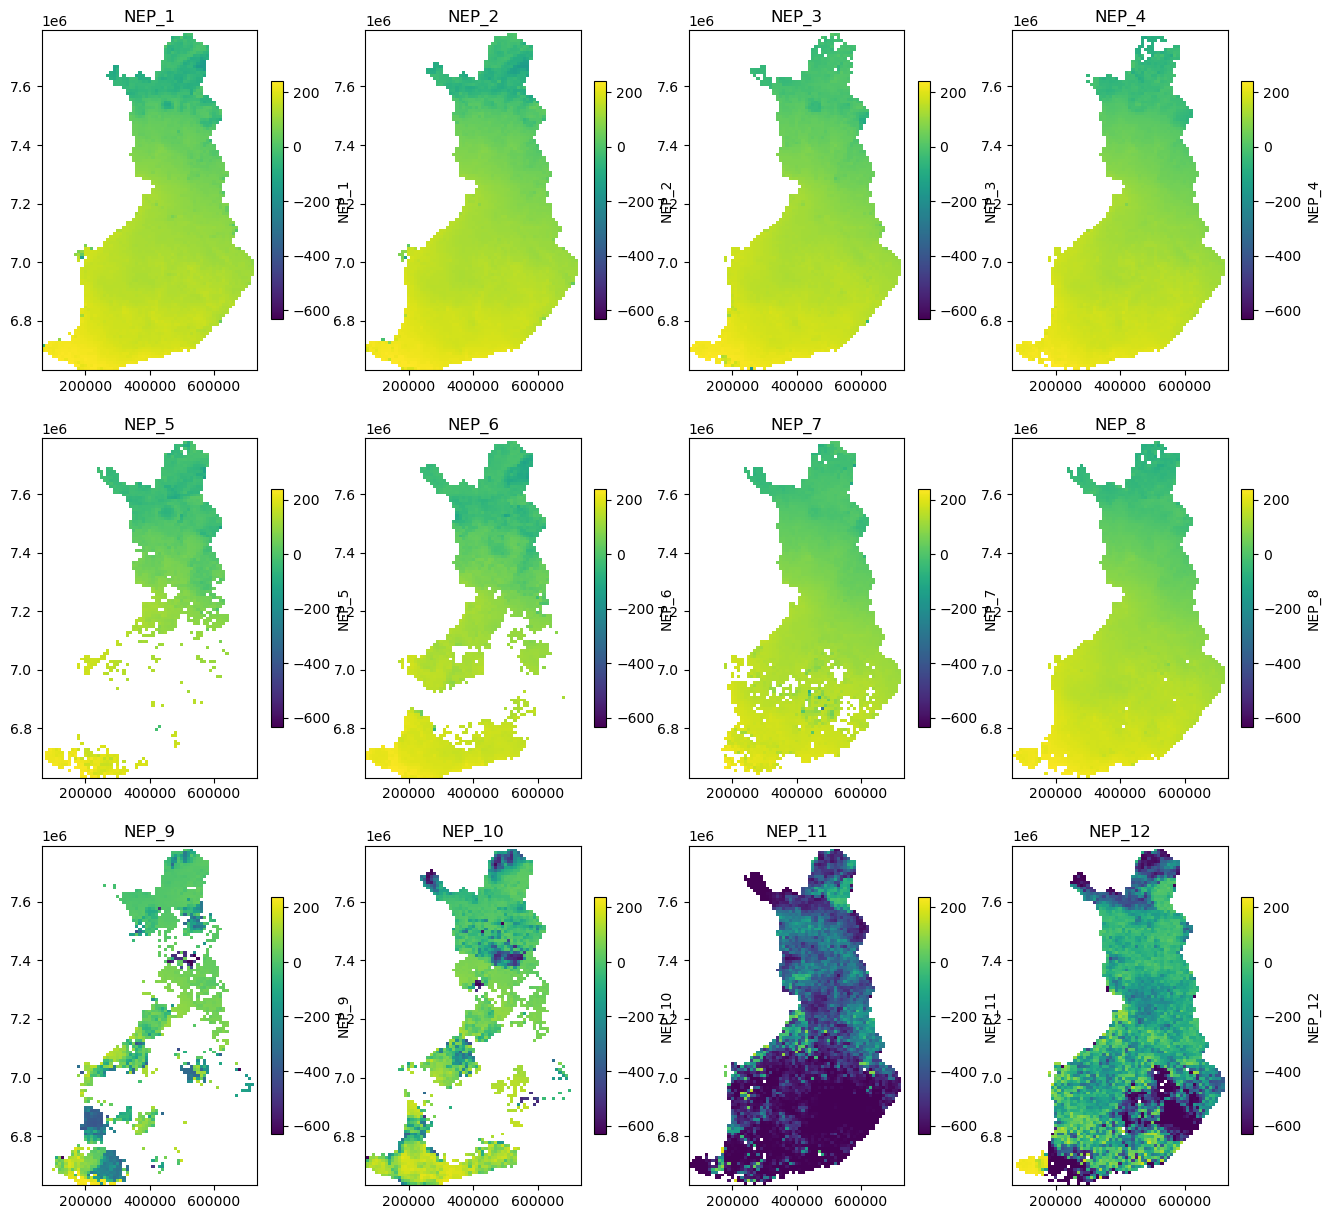

In [5]:
# Set keyword to filter variables
plot_only = 'NEP'  # or 'RECO', 'NEP', 'BAL', etc.
fig_file = f'/scratch/project_2000908/nousu/mNFI_to_NEP/FIGS/{plot_only}_plots.png'

# Filter variables from fluxes that contain the keyword
selected_vars = [v for v in fluxes.data_vars if plot_only.upper() in v.upper()]

# Compute common vmin and vmax across selected variables
all_values = np.concatenate([
    fluxes[var].values[np.isfinite(fluxes[var].values)].ravel()
    for var in selected_vars
])
vmin = np.min(all_values)
vmax = np.max(all_values)

# Determine layout
n_vars = len(selected_vars)
n_cols = 4
n_rows = int(np.ceil(n_vars / n_cols))

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Plot each selected variable
for i, var in enumerate(selected_vars):
    fluxes[var].plot(
        ax=axes[i], cmap="viridis",
        vmin=vmin, vmax=vmax,
        cbar_kwargs={'shrink': 0.7}
    )
    axes[i].set_title(var)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide unused subplots
for j in range(n_vars, len(axes)):
    axes[j].axis("off")

# Save to file
plt.savefig(fig_file, dpi=300, bbox_inches='tight')
plt.show()

In [6]:
output_file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/FINAL_LAYERS/carbon_fluxes.nc'
fluxes.to_netcdf(output_file)
fluxes.close()

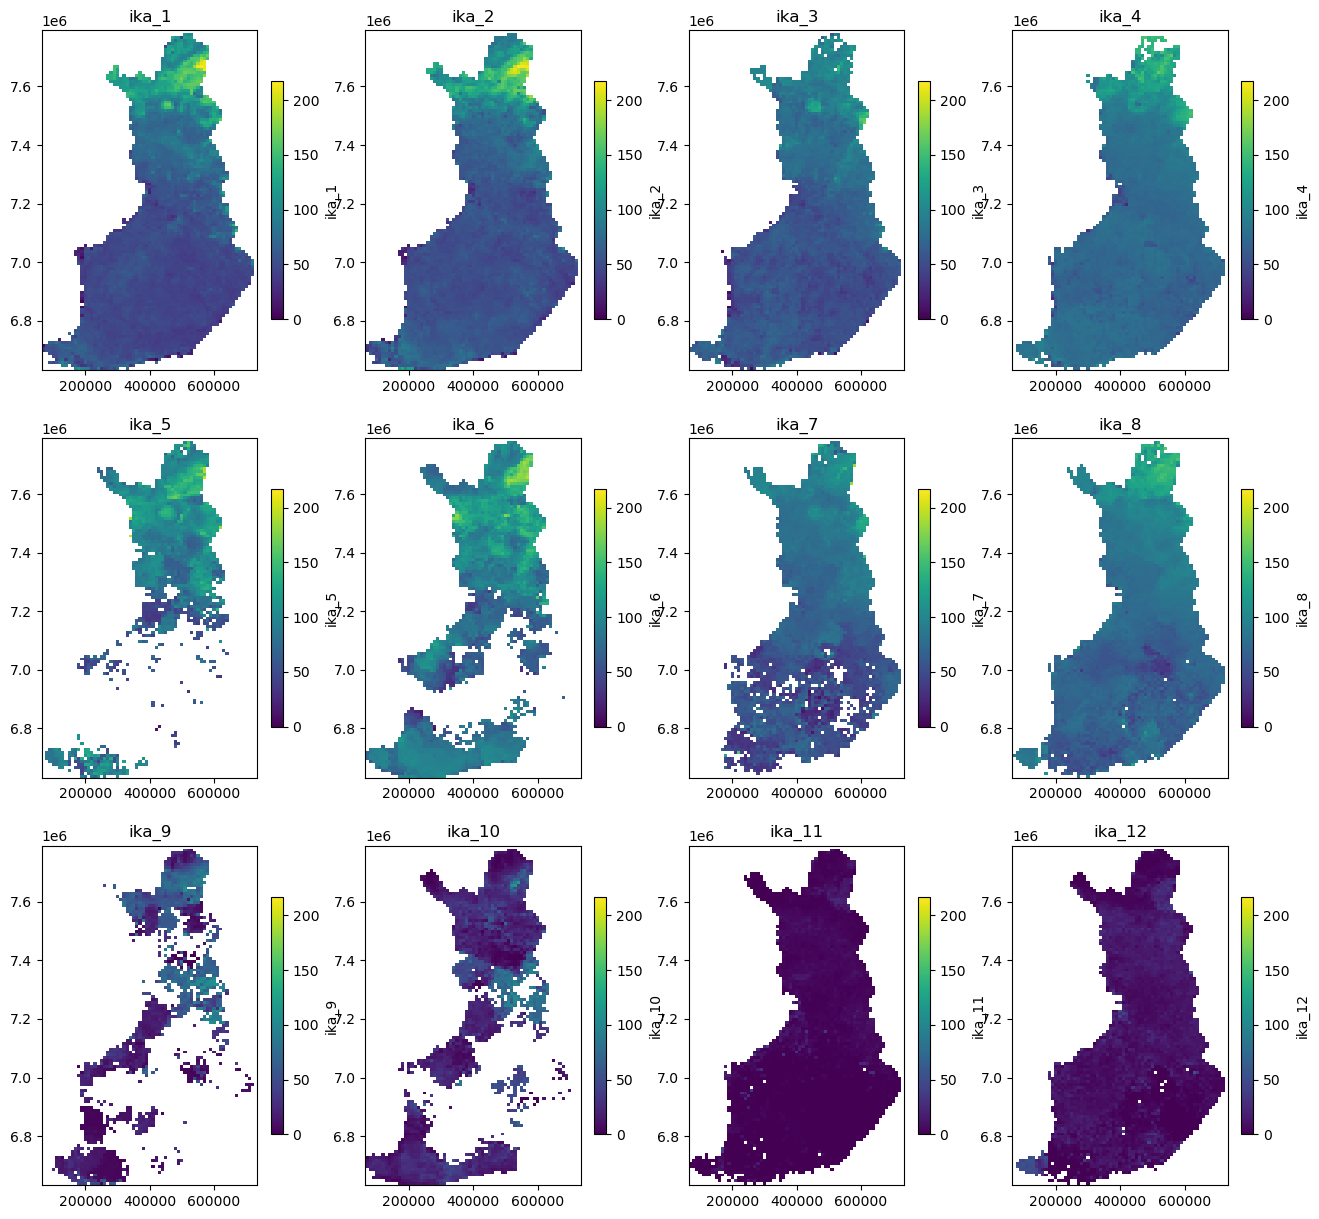

In [7]:
# Dataset and output figure path
plot_only = 'ika_'
fig_file = f'/scratch/project_2000908/nousu/mNFI_to_NEP/FIGS/{plot_only}plots.png'

# Select variables matching 'ika_'
selected_vars = [v for v in mnfi.data_vars if plot_only in v.lower()]

# Compute common vmin and vmax
all_values = np.concatenate([
    mnfi[var].values[np.isfinite(mnfi[var].values)].ravel()
    for var in selected_vars
])
vmin = np.min(all_values)
vmax = np.max(all_values)

# Determine layout
n_vars = len(selected_vars)
n_cols = 4
n_rows = int(np.ceil(n_vars / n_cols))

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Plot each selected variable
for i, var in enumerate(selected_vars):
    mnfi[var].plot(
        ax=axes[i], cmap="viridis",
        vmin=vmin, vmax=vmax,
        cbar_kwargs={'shrink': 0.7}
    )
    axes[i].set_title(var)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide unused subplots
for j in range(n_vars, len(axes)):
    axes[j].axis("off")

# Save and show figure
plt.savefig(fig_file, dpi=300, bbox_inches='tight')
plt.show()

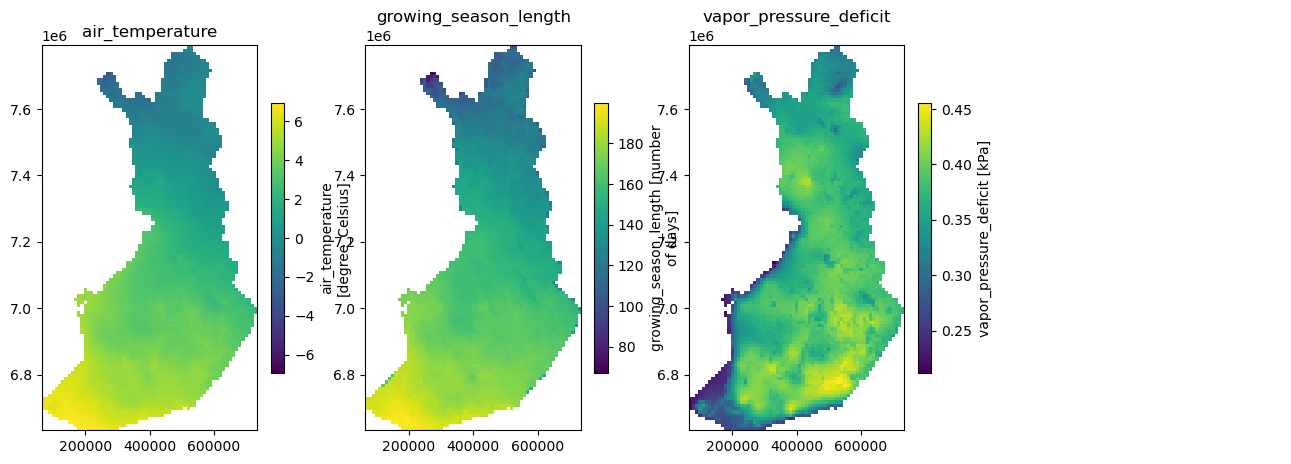

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Output file path
fig_file = '/scratch/project_2000908/nousu/mNFI_to_NEP/FIGS/meteo_plots.png'

# Get all variable names from the meteo dataset
selected_vars = list(meteo.data_vars)

# Determine layout
n_vars = len(selected_vars)
n_cols = 4
n_rows = int(np.ceil(n_vars / n_cols))

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Plot each variable with automatic color scaling
for i, var in enumerate(selected_vars):
    meteo[var].plot(
        ax=axes[i], cmap="viridis",
        cbar_kwargs={'shrink': 0.7}
    )
    axes[i].set_title(var)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide unused subplots
for j in range(n_vars, len(axes)):
    axes[j].axis("off")

# Save and show the figure
plt.savefig(fig_file, dpi=300, bbox_inches='tight')
plt.show()